# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Открываем файл с данными и изучим общую информацию. 

In [1]:
import pandas as pd
import seaborn as sns

In [3]:
pd.set_option('display.max_columns', 50) 
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
# параметры для корректного отображения таблиц и более удобного их анализа

In [4]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.00000,108.00000,2019-03-07T00:00:00,3,2.70000,16.00000,51.00000,8,NaN,False,False,25.00000,NaN,Санкт-Петербург,18863.00000,16028.00000,1.00000,482.00000,2.00000,755.00000,NaN
1,7,3350000.00000,40.40000,2018-12-04T00:00:00,1,NaN,11.00000,18.60000,1,NaN,False,False,11.00000,2.00000,посёлок Шушары,12817.00000,18603.00000,0.00000,NaN,0.00000,NaN,81.00000
2,10,5196000.00000,56.00000,2015-08-20T00:00:00,2,NaN,5.00000,34.30000,4,NaN,False,False,8.30000,0.00000,Санкт-Петербург,21741.00000,13933.00000,1.00000,90.00000,2.00000,574.00000,558.00000
3,0,64900000.00000,159.00000,2015-07-24T00:00:00,3,NaN,14.00000,NaN,9,NaN,False,False,NaN,0.00000,Санкт-Петербург,28098.00000,6800.00000,2.00000,84.00000,3.00000,234.00000,424.00000
4,2,10000000.00000,100.00000,2018-06-19T00:00:00,2,3.03000,14.00000,32.00000,13,NaN,False,False,41.00000,NaN,Санкт-Петербург,31856.00000,8098.00000,2.00000,112.00000,1.00000,48.00000,121.00000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

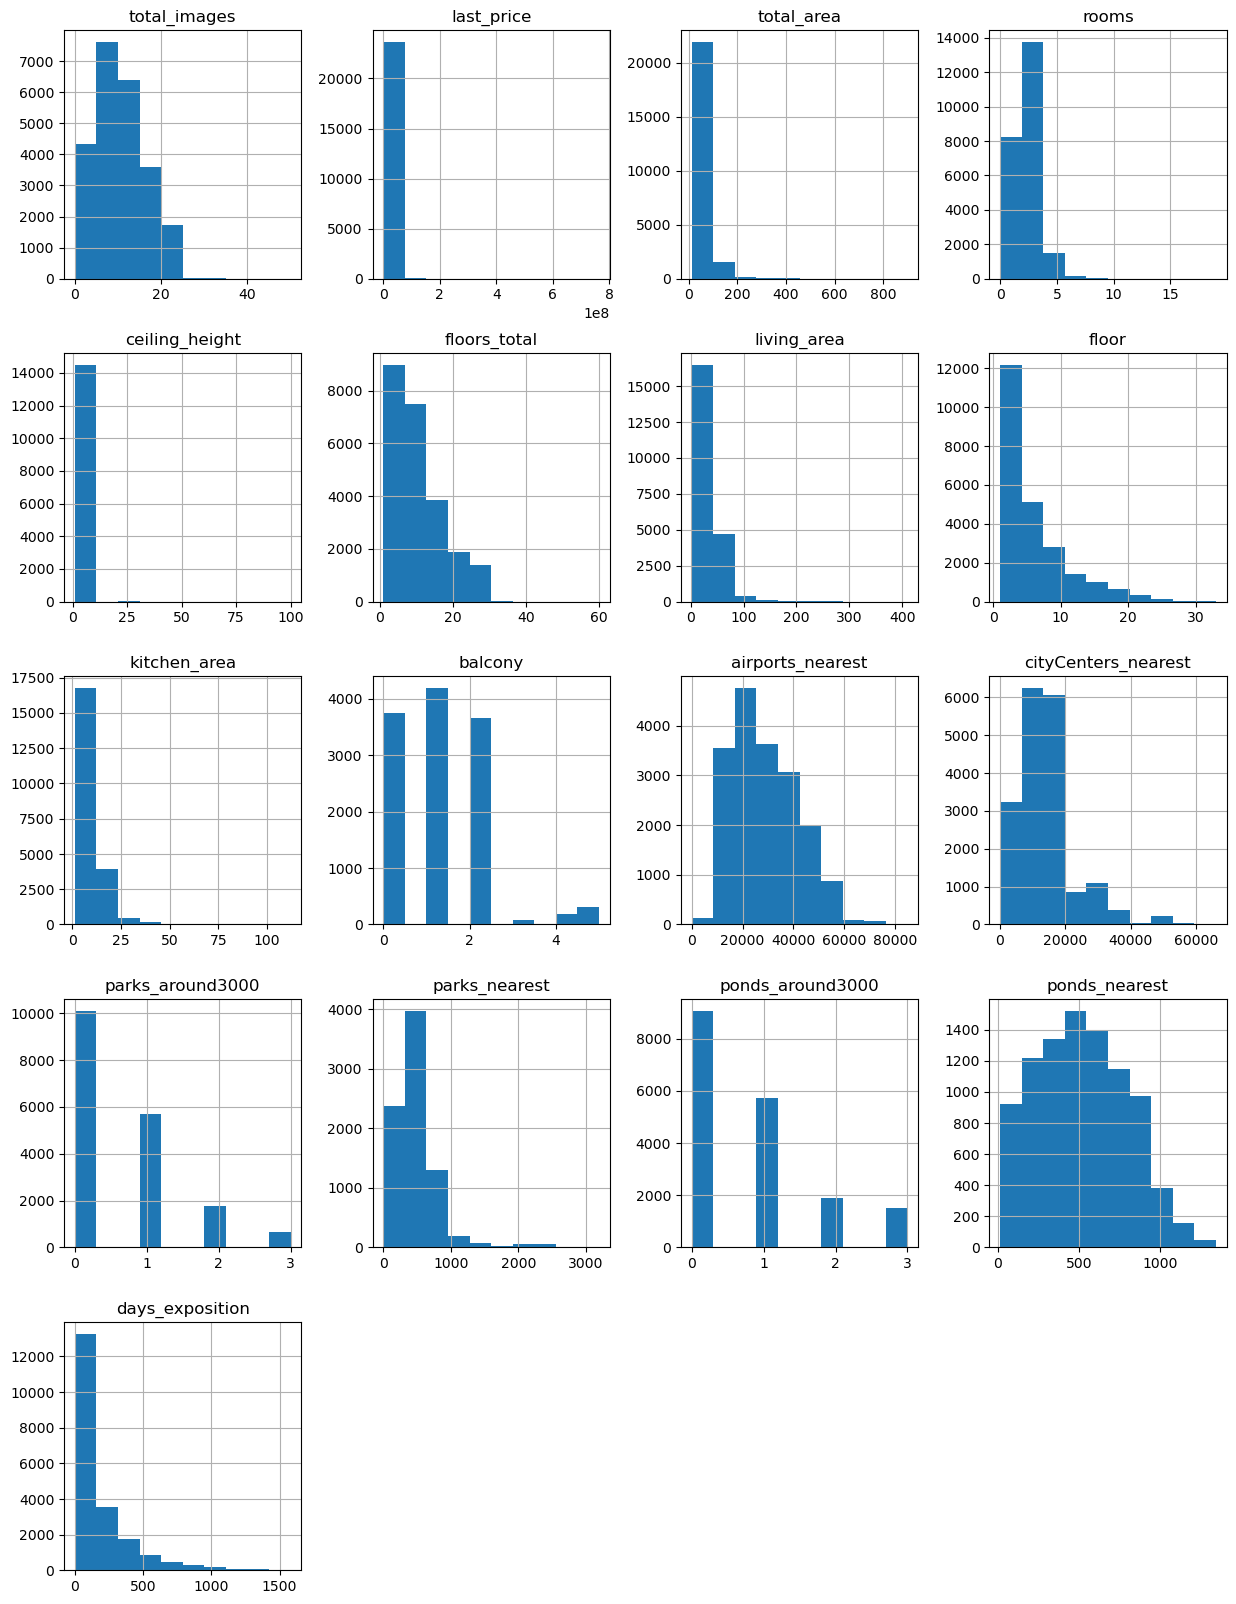

In [6]:
df.hist(figsize=(15, 20));

Есть выброс на графике количества балконов(позже выяснится, что более 11 тыс значений имеют NaN в показателе, таким образом при их обработке выброс на 5 балконах не будет таким выпадающим). Неинформативная гистограмма распределения цен. Есть небольшие выбросы в значениях на самых больших показателях

### Предобработка данных

In [7]:
df.isna().sum() # поиск количества NaN значений

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [8]:
median_ceiling = df['ceiling_height'].median()
df['ceiling_height'] = df['ceiling_height'].fillna(median_ceiling)
#высота потолка не указана, потому что арендодатель, скорее всего, не в курсе его высоты, используем медианное значение(чтобы взять похожее на правду)

In [9]:
df['balcony'] = df['balcony'].fillna(0)
#заменяем пропуски в балконах на ноль, тк балкона в квартире скорее всего нет

In [10]:
df[df['floors_total'].isna()] #убедиться, что этажей не 1 всего в доме в этих объявлениях
df['floors_total'] = df['floors_total'].fillna(df['floors_total'].median())
# скорее всего просто забыли указать количество 

In [11]:
df['is_apartment'] = df['is_apartment'].fillna(True)
# в столбце присутствовали только значения False, следовательно заменяем пропуски на True

In [12]:
df = df.dropna(subset=['locality_name']).reset_index()
df.isna().sum()
#небольшое количество. можно удалить

index                       0
total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1898
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2269
balcony                     0
locality_name               0
airports_nearest         5534
cityCenters_nearest      5511
parks_around3000         5510
parks_nearest           15586
ponds_around3000         5510
ponds_nearest           14565
days_exposition          3180
dtype: int64

- были заменены данные по высоте потолка на медианные, поскольку данные не настолько важные, чтобы убирать эти квартиры из выборки(возможно, продавец забыл указать высоту)
- пропуски в столбце с балконами заменены на 0, так как скорее всего отсутствие значения равно отсутствию балкона
- заменены значения суммарного количества этажей на медианные. проверили строки с пропусками(вдруг там всего один этаж везде). пропусков было всего 86, поэтому можно заменить на медианное(а не конкретное) значение
- в колонке is_apartment все значения, которые не NaN, равны False, следовательно все пропущенные заменены на True
- заменили все значения locality_name на Санкт-Петербург. Поскольку их было всего 49, то добавили самый крупный город, чтобы не испортить конечную статистику

In [13]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S') #перевод в режим даты для наглядности

In [14]:
df['last_price'] = df['last_price'].astype(int) #суммы большие можно избавиться от копеек
df['floors_total'] = df['floors_total'].astype(int) # не может быть не точного количества этажей
df['balcony'] = df['balcony'].astype(int)

Изменены типы данных в стоблце first_day_exposition на datetime и в столбцах last_price и floors_total на integer

In [15]:
df['locality_name'] = [elem.replace('поселок городского типа ', '') for elem in df['locality_name']]
df['locality_name'] = [elem.replace('посёлок городского типа ', '') for elem in df['locality_name']]
df['locality_name'] = [elem.replace('городской поселок ', '') for elem in df['locality_name']]
df['locality_name'] = [elem.replace('городской посёлок ', '') for elem in df['locality_name']]
df['locality_name'] = [elem.replace('посёлок станции ', '') for elem in df['locality_name']]
df['locality_name'] = [elem.replace('посёлок ', '') for elem in df['locality_name']]
df['locality_name'] = [elem.replace('поселок ', '') for elem in df['locality_name']]
df['locality_name'] = [elem.replace('деревня ', '') for elem in df['locality_name']]
df['locality_name'] = [elem.replace('садовое товарищество ', '') for elem in df['locality_name']]
df['locality_name'] = [elem.replace('при железнодорожной станции ', '') for elem in df['locality_name']]
df['locality_name'] = [elem.replace('садоводческое некоммерческое товарищество ', '') for elem in df['locality_name']]
# поскольку сортировка на типы поселений не требуется, то можно просто избавиться от них, заодно упростить чистку неявных дубликатов

Чтобы избавиться от неявных дубликатов в названиях населенных пунктов были убраны типы поселений (поскольку группировка по типам не нужна, можно так сделать)

In [16]:
df = df[(df['total_area'] < 250) & (df['total_area'] > 15)] 
# убираем слишком маленькие и слишком большие квартиры. их либо мало, либо ошибка в данных

In [17]:
df = df[(df['rooms'] < 10) & (df['rooms'] != 0)]
# убираем квартиры с слишком большим количеством комнат и равным от 1 до 3 квартир в выборке
# такие значения либо ошибочны, либо не являются нужными в выборке
# также убираем 197 квартир со значением 0 

In [18]:
df = df[(df['ceiling_height'] < 5) & (df['ceiling_height'] > 2)]
# убираем все значения высоты потолков ниже 2 метров и выше 5 метров

In [19]:
df = df[(df['floors_total'] < 36)]
# убираем неправдоподобные(слишком высокие) этажи. на которых к тому же по одному объявлению

In [20]:
df= df[(df['last_price'] < 50000000) & (df['last_price'] > 200000)]

Были убраны из выборки редкие и аномальные данные в столбцах total_area, rooms, ceiling_height, floors_total

### Посчитайте и добавьте в таблицу новые столбцы

In [21]:
df['one_metre_price'] = (df['last_price']/df['total_area']).round() # цена за 1 кв. м. 

In [22]:
df['weekday_publicated'] = df['first_day_exposition'].dt.weekday # день недели публикации
df['month_publicated'] = df['first_day_exposition'].dt.month # месяц публикации
df['year_publicated'] = df['first_day_exposition'].dt.year # год публикации


In [23]:
def categorize_floors(floors): # функция для рассчета типа этажа квартиры
    floor = floors['floor']
    floors_total = floors['floors_total']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else: 
        return 'другой'

In [24]:
df['floor_category'] = df.apply(categorize_floors, axis = 1) # тип этажа квартиры

In [25]:
df['km_to_city_centre'] = (df['cityCenters_nearest']/1000).round() # расстояние до центра города в км

In [26]:
df['price_mln'] = (df['last_price']/1000000) # новый столбец с ценами в млн для визуализации

Добавлены дополнительные стоблцы в общую таблицу

### Проведите исследовательский анализ данных

**1. Анализ основных показателей датафрейма**

array([[<Axes: title={'center': 'total_area'}>,
        <Axes: title={'center': 'living_area'}>],
       [<Axes: title={'center': 'kitchen_area'}>, <Axes: >]], dtype=object)

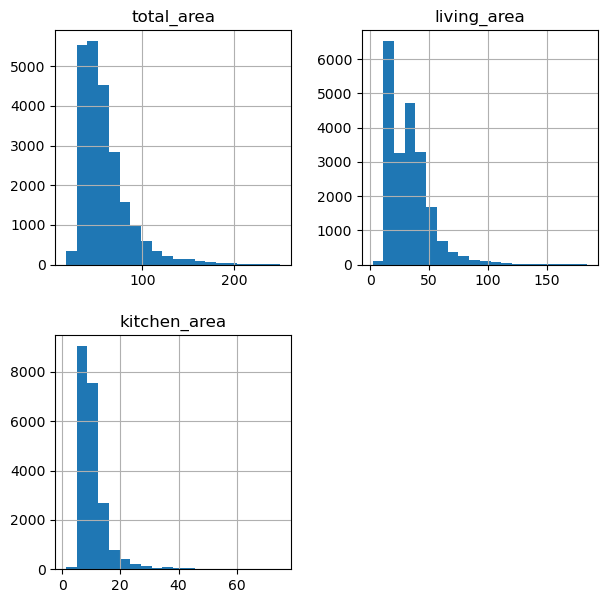

In [27]:
df.hist(['total_area', 'living_area', 'kitchen_area'], bins=20, figsize=(7,7))
# гистограммы общей площади, жилой площади, площади кухни

1. Общая площадь. Большинство объявлений были представлены площадью до 100м. Пик значений приходится на квартиры меньше 50 м2
2. Жилая площадь. Все значения лежат в диапазоне до 100 м2, а абсолютное большинство до 50 м2 с пиком значений на уровне 30 м2
3. Площадь кухни. Все значения лежат в диапазоне до 50 м2. Пик значений лежит на 10 м2, в три раза меньше объявлений с кухнями 5 м2 и 15 м2. Остальные значения сильно малы

<Axes: >

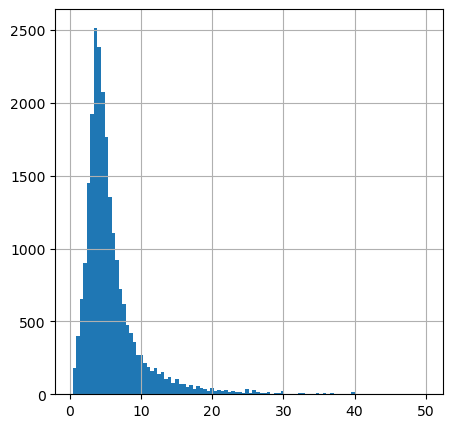

In [28]:
df['price_mln'].hist(bins=100, figsize=(5,5)) # гистограмма стоимости квартир

4. Стоимость квартиры. Большинство квартир стоили до 10 млн. рублей, хотя отмечается угасающий ход графика до стоимости в 20 млн с достаточным количеством в диапазоне до 15 млн. рублей. Пиковых значений график достигает на стоимости 3,5 млн. рублей. Преобладающее большинство квартир было продано за стоимость от 1 млн до 7 млн рублей

<Axes: >

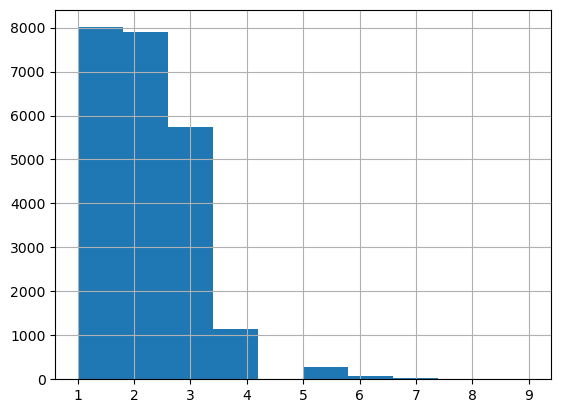

In [29]:
df['rooms'].hist() # гистограмма количества комнат

5. Количество комнат. По 8 тысяч объявлений в датасете имеют значения 1 и 2 комнаты. Чуть меньше 6 тысяч объявлений представлены 3 комнатными квартирами. Чуть больше тысячи представлены четырехкомнатными квартирами. 

<Axes: >

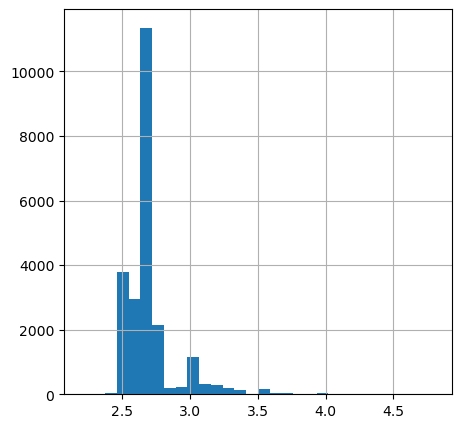

In [30]:
df['ceiling_height'].hist(bins=30, figsize=(5,5)) # гистограмма высоты потолков

6. Высота потолков. Практически все квартиры в выборке имеют высоту потолков 3 и меньше метров. Самое большое количество квартир с высотой потолков 2.7+-0,5 м, что обусловлено стандартизацией высоты потолков в новом жилье в Санкт-Петербурге. Около 7 тыс. квартир имеют высоту потолков 2,5-2,6 метра. Большинство квартир имеют высоту потолков 2.5-2.8м(22 тыс. кв.), за исключением небольшого пика на 3м. в виде 1,5 тыс. квартир, которые скорее всего представляют собой жилье комфорт класса, либо квартиры на последних этажах. 

array([[<Axes: title={'center': 'floor'}>,
        <Axes: title={'center': 'floors_total'}>]], dtype=object)

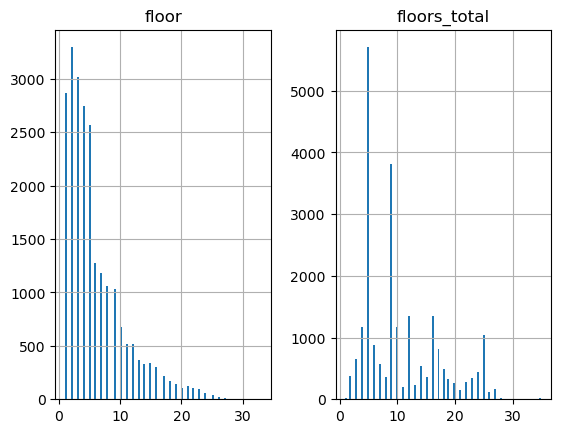

In [31]:
df.hist(['floor', 'floors_total'], bins=100) # гистограммы этажа квартиры и общего количества этажей в доме

<Axes: >

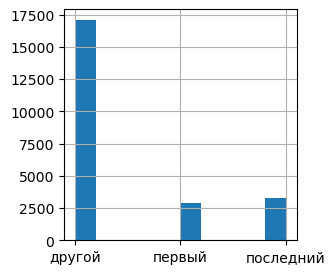

In [32]:
df['floor_category'].hist(figsize=(3,3)) # категория этажа в объявлении

7. Этаж квартиры. Большинство квартир были проданы на первых десяти этажах, где из них 1-5 этажи указаны в  13 тысячях объявлений, а квартиры на 6-10 этажах были указаны еще в 5 тыс. объявлений. Остальное поделили квартиры на этажах с 10 по 20 и с 20 по 30 в соотношении 1:2
8. Тип этажа квартиры. Квартиры, находящиеся на первом или последнем этажах, входят в 7 тысяч объявлений и делятся поровну, когда как остальные составляют 17 тысяч объявлений. 
9. Всего этажей в доме. Самое большое количество квартир было продано в 5 и 10 этажных домах(6 тыс. и  4 тыс. объявлений соответственно). Остальные пики выделяются на квартирах в домах с 12, 16 и 25 этажами(в среднем, чуть больше 1 тыс. объявлений на каждую категорию)

array([[<Axes: title={'center': 'cityCenters_nearest'}>,
        <Axes: title={'center': 'airports_nearest'}>],
       [<Axes: title={'center': 'parks_nearest'}>, <Axes: >]],
      dtype=object)

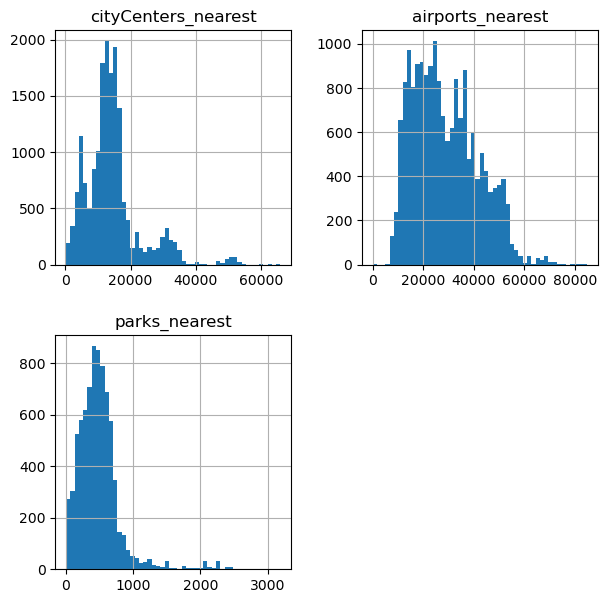

In [33]:
df.hist(['cityCenters_nearest', 'airports_nearest', 'parks_nearest'], figsize=(7,7), bins=50)
# гистограммы расположения квартиры относительно центра города, аэропорта и ближайшего парка

10. Растояние до центра города. Основная масса объявлений расположена в 20 км от центра города, с увеличением количества по закономерности "чем дальше, тем больше". Также отмечается небольшой пик на расстоянии 30 км, что связано, скорее всего, с каким-то новым построенным жилым массивом на окраине города(либо недалеко от КАД)
11. Расстояние до аэропорта. Поскольку в Санкт-Петербурге аэропорт всего один и находится он на достаточном отдалении от города, то нет ни одного объявления в радиусе 10 км от него. Также поскольку, он находится на юге города, то объявления по расстоянию до аэропорта распределились практически равномерно в диапазоне от 15 до 50 км.
12. Расстояние до ближайшего парка. Санкт-Петербург представлен достаточно большим количеством зеленых насаждений, а также парков и зеленых зон в черте города, в связи с этим, практически все объявления квартир, где был указан данный параметр, расположены не более чем в километре от зеленой зоны. 

array([[<Axes: title={'center': 'weekday_publicated'}>,
        <Axes: title={'center': 'month_publicated'}>]], dtype=object)

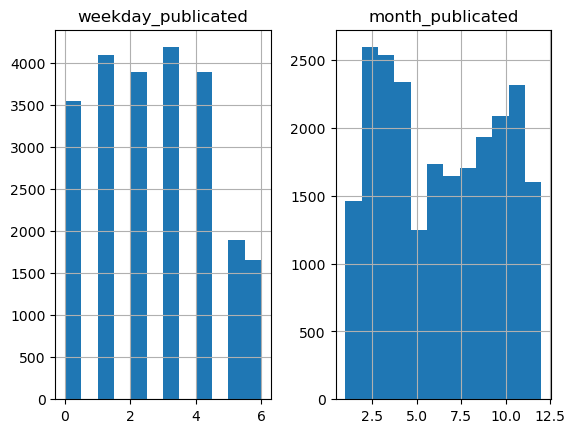

In [34]:
df.hist(['weekday_publicated', 'month_publicated'], bins=12)
# гистограммы распределения по дням недели и по месяцам, когда продавец выкладывал объявление

13. День и месяц публикации объявления. Прослеживается тенденция на увеличение интереса в продаже квартиры у людей в рабочие дни и в зимние месяцы. Чем ближе лето и большое количество праздников, тем меньше объявлений выкладывается. То же стоит отметить и про субботу-воскресенье, в эти дни продавцам не хочется думать о делах и количество объявлений появляется реже. 

**2. Изучение времени продажи квартиры**

<Axes: >

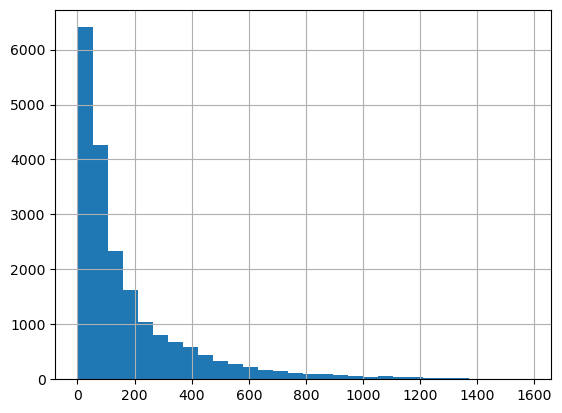

In [35]:
 df['days_exposition'].hist(bins=30)

In [36]:
df['days_exposition'].describe()

count   20084.00000
mean      180.53127
std       219.33261
min         1.00000
25%        45.00000
50%        95.00000
75%       231.00000
max      1580.00000
Name: days_exposition, dtype: float64

array([[<Axes: title={'center': 'days_exposition'}>]], dtype=object)

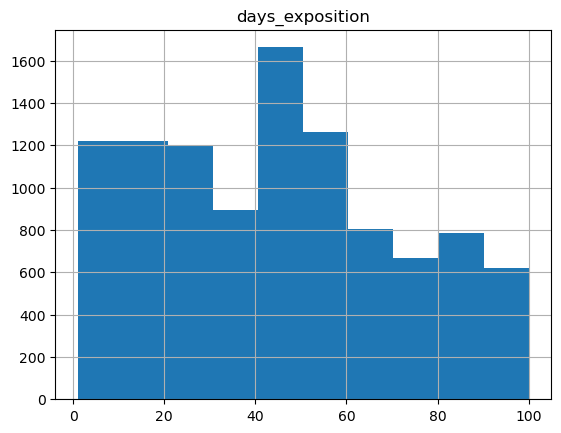

In [37]:
df.query('(days_exposition <= 100)').hist('days_exposition') # рассмотрим данные по продажам в первые 100 дней подробнее

Среднее время продажи квартиры составляет полгода, когда медианное значение около 3 месяцев. Также достаточно большое количество(около 20%) квартир было продано за год и полтора. 
Быстрой продажей можно считать ту, которая была совершена за время меньше 3 месяцев, в то же время необычно долгим значением будет являться объявление, висящее больше 9 месяцев. <br>
Если рассмотреть подробнее график в диапазоне до 100 дней, то можно увидеть, что лучше всего квартиры продавались в первые 20 дней(что связано со свежестью объявления и его нахождением в списке сайта, а также продажи были скорее всего самого ходового дешевого жилья) и в пределах от 40 до 60 дней имеется самый большойй пик продаж. Соответственно, значение средней хорошей продажи лежит в пределах до 60 дней

**3. Изучение зависимости стоимости квартиры от различных факторов**

<Axes: xlabel='price_mln', ylabel='total_area'>

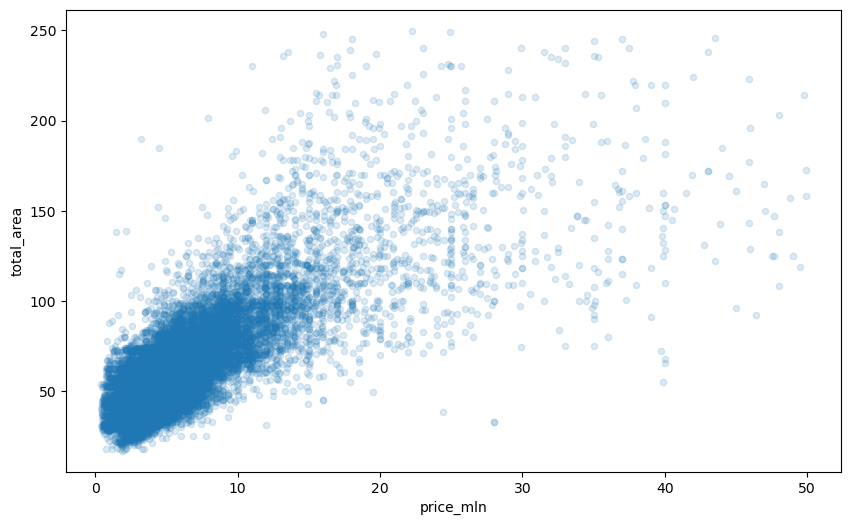

In [38]:
# график зависимости стоимости квартиры от общей площади квартиры

df.plot(x='price_mln', y='total_area', kind='scatter', alpha=0.15, figsize=(10,6) )

Зависимость стоимости квартиры от ее общей площади прямая: чем больше площадь, тем выше стоимость. 

<Axes: xlabel='price_mln', ylabel='living_area'>

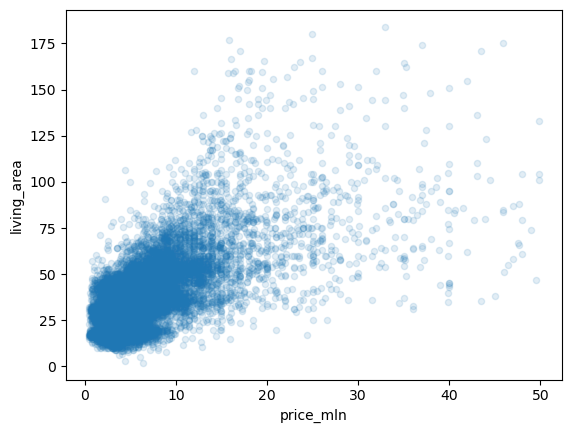

In [39]:
# график зависимости стоимости квартиры от жилой площади

df.plot(x='price_mln', y='living_area', kind='scatter', alpha=0.13 )

Увеличение жилой площади также сказывается на увеличении цены квартиры, как и общей площади

<Axes: xlabel='price_mln', ylabel='kitchen_area'>

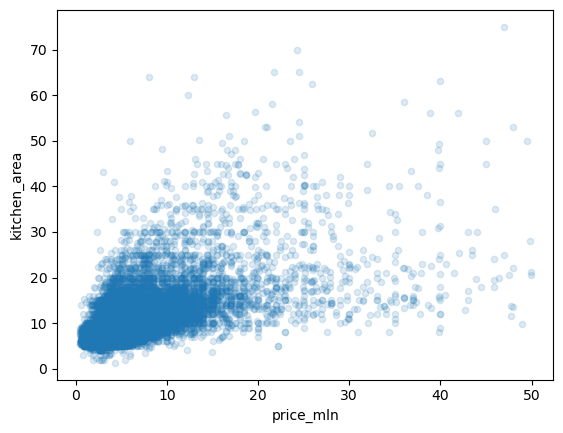

In [40]:
# график зависимости стоимости квартиры от площади кухни

df.plot(x='price_mln', y='kitchen_area', kind='scatter', alpha=0.15 )

Поскольку площадь кухни имеет достаточно ограниченный диапазон, то зависимость между ее площадью и итоговой стоимостью менее явная, чем в выше указанных параметрах

In [41]:
# таблица зависимости стоимости квартиры от количества комнат
df.pivot_table(index='rooms', values='price_mln', aggfunc=['median', 'mean'])

,median,mean
,price_mln,price_mln
rooms,,
1,3.60000,3.83070
2,4.77000,5.52262
3,6.19000,7.72413
4,8.90000,11.14094
5,12.78000,15.39404
6,16.50000,17.74907
7,17.90000,20.27306
8,18.00000,20.54143


Стоимость квартиры напрямую зависит от количества комнат в ней, что подтверждается табличными данными средних и медианных значений. Как правило, чем больше комнат, тем дороже квартира

,price_mln,total_area,living_area,kitchen_area,rooms
price_mln,1.00000,0.77720,0.67186,0.59727,0.48923
total_area,0.77720,1.00000,0.93017,0.56981,0.79344
living_area,0.67186,0.93017,1.00000,0.34520,0.87632
kitchen_area,0.59727,0.56981,0.34520,1.00000,0.21493
rooms,0.48923,0.79344,0.87632,0.21493,1.00000


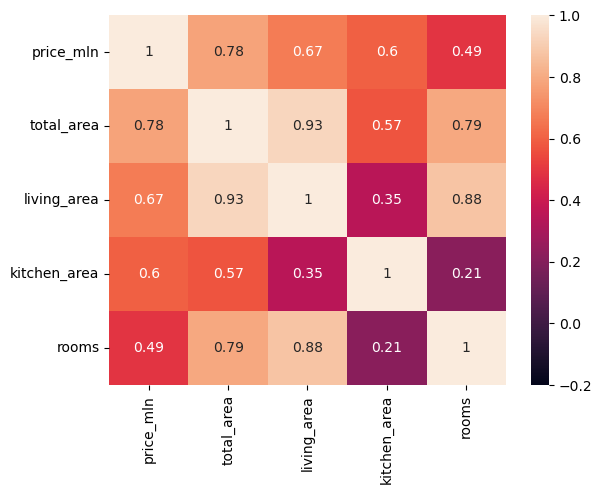

In [42]:
display(df[['price_mln', 'total_area', 'living_area', 'kitchen_area', 'rooms']].corr())
sns.heatmap(df[['price_mln', 'total_area', 'living_area', 'kitchen_area', 'rooms']].corr(), vmin=-0.2, vmax=1, annot=True);

Прослеживается очень высокая зависимость между ценой и общей площадью квартиры. Также очевидная связь есть между общей площадью и количеством комнат(чем их больше, тем больше площадь). Также цена зависит от жилой площади немногим меньше, чем от общей площади. Площадь кухни влияет уже значительно меньше на итоговую стоимость квартиры
Также при изучении зависимости итоговой цены относительно количества комнат, можно заметить, что корреляция уже не настолько значительная, поскольку разные объявления имеют свои дополнительные отличительные особенности, которые могут повысить в цене однокомнатную квартиру и понизить трехкомнатную(маленькая трешка в Гатчине будет стоить меньше, чем большая однушка/двушка на Крестовском острове

In [43]:
# таблица зависимости стоимости квартиры от типа этажа
df.pivot_table(index='floor_category', values='price_mln', aggfunc=['median', 'mean'])

,median,mean
,price_mln,price_mln
floor_category,,
другой,4.85000,6.21552
первый,3.90000,4.59548
последний,4.30000,5.74755


В основном, судя по средним и медианным значениям стоимости квартир, объявления о квартирах на первом и последнем этажах имеют значения стоимости немного ниже, чем на других этажах. Самые дешевые квартиры на первом этаже

In [44]:
# таблица зависимости стоимости квартиры от дня недели выставления объявления
df.pivot_table(index='weekday_publicated', values='price_mln', aggfunc=['median', 'mean'])

,median,mean
,price_mln,price_mln
weekday_publicated,,
0,4.65000,5.99579
1,4.75000,5.98046
2,4.70000,6.02868
3,4.62500,6.10968
4,4.59000,5.80636
5,4.55000,5.70605
6,4.55000,5.79752


Отмечается, что самые выгодные предложения появлялись по выходным. Стоит отметить, что разница небольшая, около 100 тыс. рублей

In [45]:
# таблица зависимости стоимости квартиры от месяца выставления объявления
df.pivot_table(index='month_publicated', values='price_mln', aggfunc=['median', 'mean'])

,median,mean
,price_mln,price_mln
month_publicated,,
1,4.60000,6.05764
2,4.65000,5.96067
3,4.68500,5.84395
4,4.80000,5.93000
5,4.50000,5.92105
6,4.40000,5.78890
7,4.60000,5.90792
8,4.60000,5.99022


Исходя из таблицы выше, можно сказать, что к лету цены на квартиры снижались, а к зиме наоборот повышались. Потенциально продавцы хотели продать квартиру побыстрее, чтобы уехать в отпуск, поэтому ставили ценник ниже

<Axes: xlabel='year_publicated'>

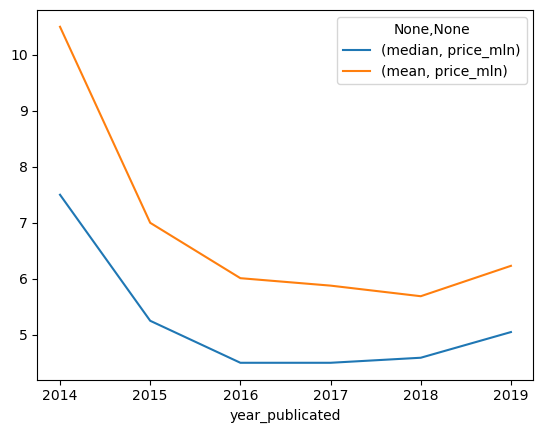

In [46]:
# таблица зависимости стоимости квартиры от года выставления объявления
df.pivot_table(index='year_publicated', values='price_mln', aggfunc=['median', 'mean']).plot()

С каждым годом средние цены на недвижимость падали, не считая 2019го года, когда кривая графика немного приподнялась наверх

**4. Поиск населенных пунктов с самой высокой и низкой стоимостью квадратного метра**

<Axes: xlabel='locality_name'>

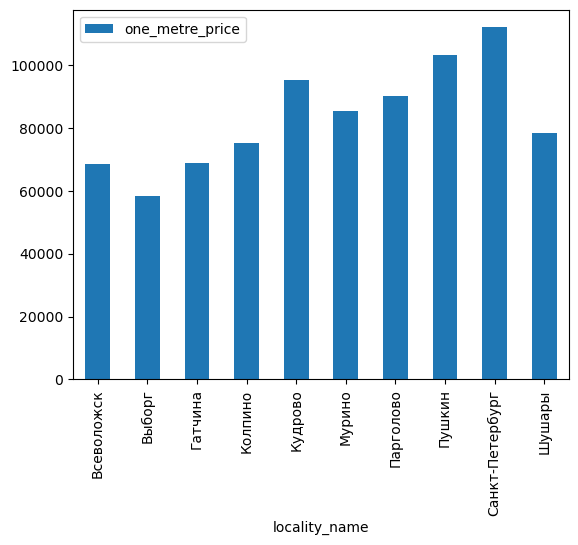

In [47]:
(
    df.query('locality_name == ["Санкт-Петербург","Мурино", "Кудрово", "Шушары", "Всеволожск", "Пушкин","Колпино", "Парголово", "Гатчина", "Выборг"]')
    .pivot_table(index='locality_name', values='one_metre_price')
    .plot(kind='bar')
)

Три самых дорогих города для покупки недвижимости являются Санкт-Петербург, Пушкин и Кудрово соответственно. Самым дешевым городом в датасете является Выборг, в связи с его сильным отдалением от Санкт-Петербурга. Стоимость квадратного метра в Санкт-Петербурге и близлежащих городах зависит от их удаленности от центра СП-б/инфраструктуры/метро/тд, а также расположения в удачном или нет со стороны экологического состояния. Например, Шушары находятся практически в городе, но в то же время в непосредственной близости располагается КАД и очень крупная промзона

**5. Изучить как стоимость объектов зависит от расстояния до центра города**

<Axes: xlabel='km_to_city_centre'>

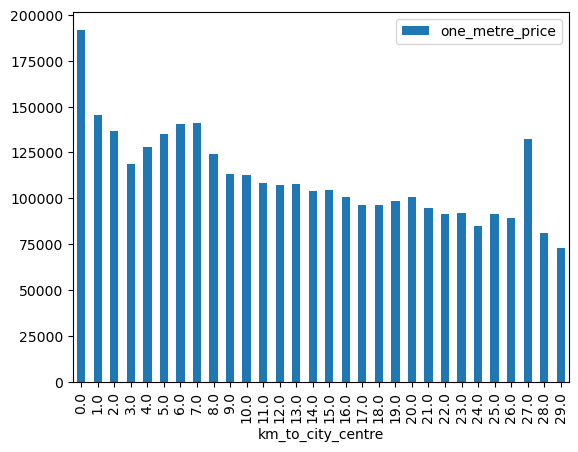

In [48]:
(
    df.query('locality_name == "Санкт-Петербург"')
    .pivot_table(index='km_to_city_centre', values='one_metre_price', aggfunc='mean')
    .plot(kind='bar')
)

 Общая тенденция изменения графика стоимости одного квадратного метра относительно удаленности от центра на уменьшение показателя. Однако, есть пара пиков на графике на 5-8 км, на 27 и на 41 км, первый пик скорее всего связан с тем, что примерно на 5 км от главпочтампта находится Петроградский район, Крестовский и Каменный остров, а также Кирочная улица. Эти районы являются одними из самых дорогих и престижных в Санкт-Петербурге. Увеличение стоимости на 27 и 41 км скорее всего связаны с тем, что это приблизительное расстояние до Сестрорецка и Репино, городов в Курортном р-не Санкт-Петербурга, которые являются одними из самых дорогих городов для покупки земли в СП-б

**Промежуточный вывод по итогам анализа** <br>
Данные визуализируются достаточно закономерно. Какие-либо аномальные ходы графиков не отмечены. Все зависимости поддаются объяснению и интерпретации

### Общий вывод

Данные за несколько последних лет о продажах квартир в г. Санкт-Петербург и близлежащих городах были предобработаны и проанализированы по многим параметрам. Были рассмотрены многие закономерности изменения стоимости квартир и их привлекательности для потенциального покупателя. Очень многие факторы являются сугубо индивидуальными для конкретной локации и основные объяснения не применимы для другой местности. В городе Санкт-Петербург и ЛО расселение происходит на подобие ядер, когда существуют несколько локаций для расселения: Кудрово, Мурино и тп привлекательны для людей, инвестирующих в жилье(покупают студии/однокомнатные квартиры на последующую продажу), центральные районы предпочтительны для людей очень высокого достатка, а также большое количество квартир в спальных районах старого фонда. Одной из особенностей города является широкая застройка в Советское время территорий домами типа "Хрущевка" и панельных домов 9-12 этажей. В связи с этим, отмечается засилие квартир в домах с количеством этажей до 10(старый фонд) и всплеск на числах около 20(новопостроенные жилые массивы). <br>
Те, кто не готов к покупке квартиры в городе или в ближайших к нему городах, рассматривают более отдаленные локации в пределах 2 часовой изохроны. В этих городах квартиры продаются по более низкой цене, как, например, в Выборге, где стоимость одного квадратного метра практически в два раза ниже, чем в Санкт-Петербурге. <br>
В связи с обильным развитием бюджетного жилищного строительства, средние цены на жилье снижались на протяжение всего изучаемого периода, за исключением незначительного повышения в 2019ом году. <br>


По анализированным данным можно производить дальнейшие исследования и найти рыночную стоимость квартир в различных задаваемых условиях в пределах обработанной локации